In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import os
from scipy.optimize import curve_fit
from line_fit_plots import line_fit_plot
from line_fit_plots import teraquop_plot

In [2]:
def import_data():
    def empty_dict():
        return(defaultdict(empty_dict))
    colour_code_data = defaultdict(empty_dict)
    XZZX_code_data = defaultdict(empty_dict)

    for dir in os.listdir("./data_18_11/"):
        if dir[0] == '6':
            data=colour_code_data
        elif dir[:4] == 'XZZX':
            data=XZZX_code_data
        for file in os.listdir("./data_18_11/" + dir):
            if os.path.isfile("./data_18_11/" +dir +"/" +file) == True:
                with open("./data_18_11/"+dir+"/"+file) as f:
                    new_data = json.load(f)
                    for distance in new_data['data']:
                        data[new_data['bias']][distance] = new_data['data'][distance]
    return(colour_code_data, XZZX_code_data)

colour_code_data, XZZX_code_data = import_data()

## Functions for calculating cc_thresholds and plotting

In [29]:
def threshold_fit(variables, B0, B1, B2, mu, pth):
    p, L = variables
    return(B0 + B1*(p-pth)*pow(L, 1/mu) + B2*pow((p-pth) * pow(L, 1/mu), 2))


def plot_per_vs_ler(per_array, ler_per_distances, ler_eb_per_distances, labels):
    for index,ler_per_distance in enumerate(ler_per_distances):
        for distance in ler_per_distance:
            plt.errorbar(per_array, ler_per_distance[distance], yerr=ler_eb_per_distances[index]
                         [distance], label='d = ' + str(distance) + str(labels[index]))
    plt.legend()
    plt.yscale("log")
    plt.xlabel("physical error rate")
    plt.ylabel("logical error rate")

def plot_ler_vs_distance(code_dict, per, code_label,marker_style,line_style,colour,ax):
    distances = []
    ler = []
    ler_eb = []
    n_qubits = []
    for distance in code_dict:
        if distance.isinstance(str):
            if int(distance) in [5, 7, 9, 13, 17, 21]:
                distances.append(int(distance))


    distances.sort()
    for distance in distances:
        if str(per) in code_dict[str(distance)].keys(): 
            if code_dict[str(distance)][str(per)]['total_run_count_all_models'] > 50:
                ler.append(code_dict[str(distance)][str(per)]['ler']/code_dict[str(distance)][str(per)]['total_run_count_all_models'])
                ler_eb.append(np.sqrt(
                    (1-ler[-1])*ler[-1]/code_dict[str(distance)][str(per)]['run_count']))
                n_qubits.append(np.sqrt(code_dict[str(distance)]["N"]))
    ax.errorbar(n_qubits, ler, label=code_label, yerr=ler_eb,marker=marker_style,linestyle=line_style,color=colour, linewidth=4,markersize=18)

    ax.set_yscale('log')
    ax.legend(loc='lower left', prop={'size': 24})
    ax.set_ylabel('Logical failure rate', size=28)
    ax.set_xlabel('Code distance $\it{d}$', size=28)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', direction='out', length=18, width=2, colors='black', grid_color='black', grid_alpha=1)
    ax.tick_params(axis='both', which='minor', direction='out', length=9, width=2, colors='black', grid_color='black', grid_alpha=1)
        
def calculate_threshold(code_dict, min_distance=1, max_distance=100, distances= None,min_per=0, max_per=1, title=None, ax=None, calculate_threshold=True, non_uniform=False):
    ler_data = []
    ler_eb_data = []
    per_data = []
    distance_data = []
    for distance in code_dict:
        if distances == None:
            if int(distance) > min_distance and int(distance) < max_distance:
                per_array = []
                ler_array = []
                ler_eb = []
                for index,per in enumerate(code_dict[distance]["per"]):
                    if per > min_per and per < max_per:
                        per_array.append(per)
                        ler_array.append(code_dict[distance]["ler"][index])
                        ler_eb.append(code_dict[distance]["ler_eb"][index])
                per_data.extend(per_array)
                ler_data.extend(ler_array)
                ler_eb_data.extend(ler_eb)
                distance_data.extend([int(distance) for _ in range(len(per_array))])
        elif int(distance) in distances:
            per_array = []
            ler_array = []
            ler_eb = []
            for index,per in enumerate(code_dict[distance]["per"]):
                if per > min_per and per < max_per:
                    per_array.append(per)
                    ler_array.append(code_dict[distance]["ler"][index])
                    ler_eb.append(code_dict[distance]["ler_eb"][index])
            per_data.extend(per_array)
            ler_data.extend(ler_array)
            ler_eb_data.extend(ler_eb)
            distance_data.extend([int(distance) for _ in range(len(per_array))])
    if calculate_threshold:
        popt, pcov = curve_fit(threshold_fit, (per_data, distance_data),
                                ler_data ,maxfev=5000) 
        if ax !=None:
            ax.axvline(x = popt[-1], color = 'black', linestyle = 'dashed')
        error = np.sqrt(np.diag(pcov))[-1]

    distance_array = []
    for distance in code_dict:
        if distances == None:
            if int(distance) > min_distance and int(distance) < max_distance:
                        distance_array.append(int(distance))
        elif int(distance) in distances:
            distance_array.append(int(distance))
    distance_array.sort()
    for distance in distance_array:

        per_array = code_dict[str(distance)]['per']
        ler_array = code_dict[str(distance)]["ler"]
        ler_eb = code_dict[str(distance)]["ler_eb"]

        if per_array != []:
            if ax != None:
                ax.errorbar(per_array,ler_array,yerr=ler_eb,label = 'd = ' + str(distance), fmt = 'o')   

        if calculate_threshold:
            if ax != None:
                ax.plot(per_array, threshold_fit(
                    (per_array, [int(distance) for _ in range(len(per_array))]), *popt), color='grey')

    if ax != None:
        ax.legend()
        ax.set_xlabel('physical error rate')
        ax.set_ylabel('logical error rate')
        ax.set_title(title)

    if calculate_threshold:
        return(popt[-1], error)


# Calculation and plots of thresholds at different biases for the DW2/3 pi 4 colour code

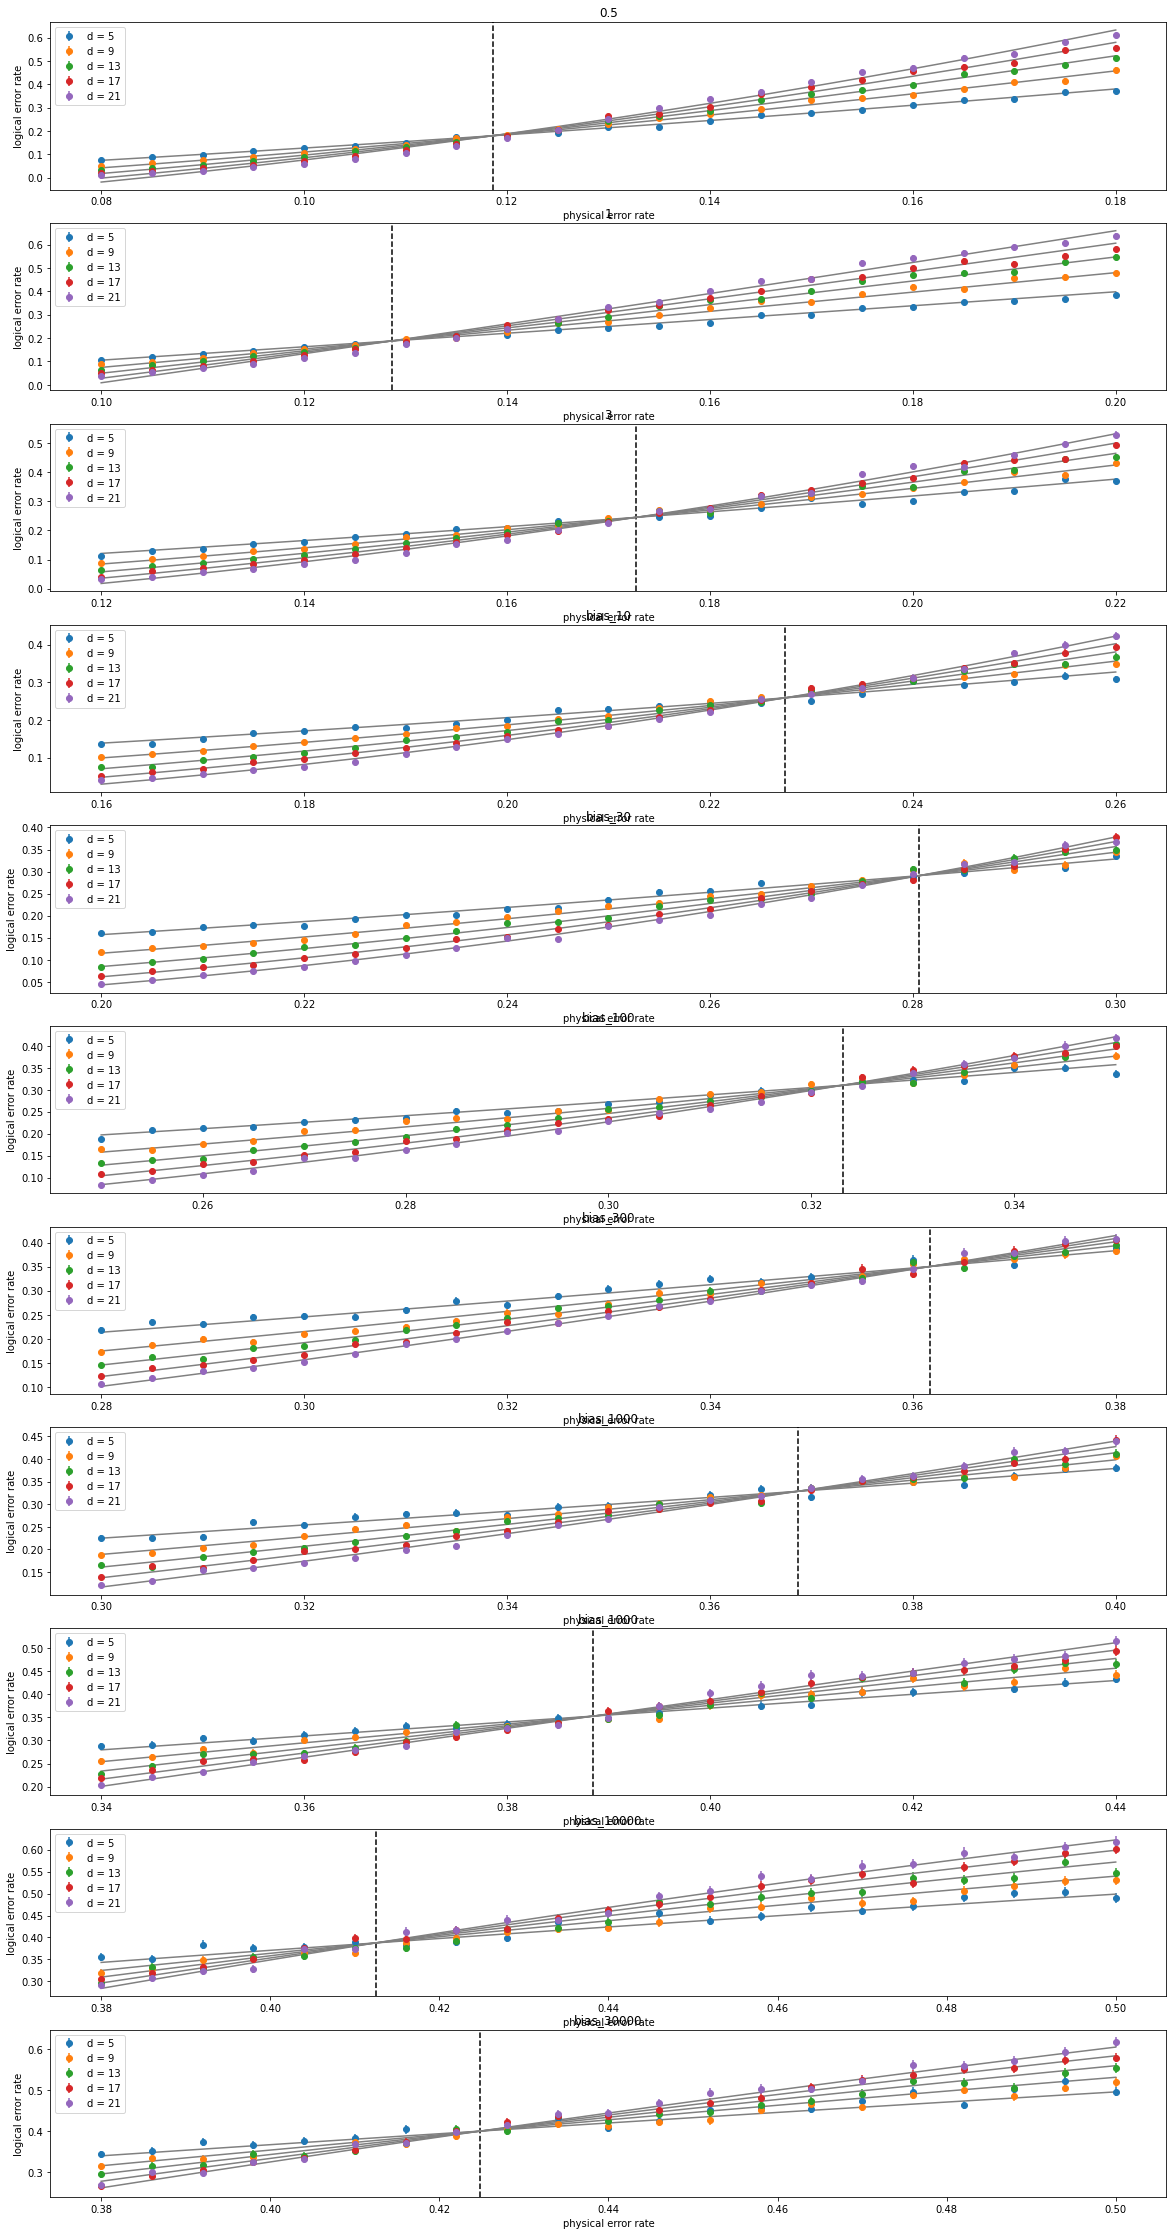

In [30]:
fig, axs = plt.subplots(nrows=11,figsize=(20,40))
cc_thresholds = dict()

cc_thresholds[0.5] = calculate_threshold(colour_code_data[0.5],ax=axs[0],title='0.5', calculate_threshold=True)
cc_thresholds[1] = calculate_threshold(colour_code_data[1],ax=axs[1],title='1',calculate_threshold=True)
cc_thresholds[3] = calculate_threshold(colour_code_data[3],ax=axs[2],title='3',calculate_threshold=True)
cc_thresholds[10]=calculate_threshold(colour_code_data[10],ax=axs[3],title='bias_' + str(10),calculate_threshold=True)
cc_thresholds[30] = calculate_threshold(colour_code_data[30],ax=axs[4],title='bias_' + str(30),calculate_threshold=True)
cc_thresholds[100] = calculate_threshold(colour_code_data[100],ax=axs[5],title='bias_' + str(100),calculate_threshold=True)
cc_thresholds[300] = calculate_threshold(colour_code_data[300],ax=axs[6],title='bias_' + str(300),calculate_threshold=True)
cc_thresholds[1000] = calculate_threshold(colour_code_data[1000],ax=axs[7],title='bias_' + str(1000),calculate_threshold=True)
cc_thresholds[3000] = calculate_threshold(colour_code_data[3000],ax=axs[8],title='bias_' + str(1000),calculate_threshold=True)
cc_thresholds[10000] = calculate_threshold(colour_code_data[10000],ax=axs[9],title='bias_' + str(10000),calculate_threshold=True)
cc_thresholds[30000] = calculate_threshold(colour_code_data[30000],ax=axs[10],title='bias_' + str(30000),calculate_threshold=True)



# Threshold vs bias plot

[0.0012999575337205717, 0.0013715440123662885, 0.0010800673091148662, 0.0008601161939245957, 0.0010942265266504845, 0.0011037202704334826, 0.0017047042818749743, 0.0013451055228817857, 0.0016541412487419097, 0.002214350087468929, 0.002303682546918789]


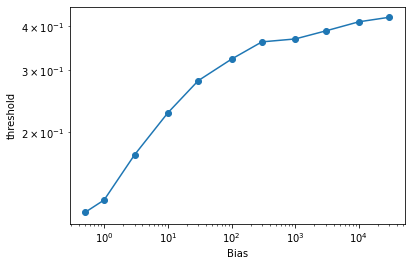

In [31]:
biases = list(cc_thresholds.keys())
threshold_plot= [thres[0] for thres in  cc_thresholds.values()]
threshold_errors = [thres[1] for thres in cc_thresholds.values()]
print(threshold_errors)
plt.errorbar(biases, threshold_plot,yerr=threshold_errors,marker='o')
plt.xlabel('Bias')
plt.ylabel('threshold')
plt.loglog()
plt.savefig('thresholdvsbias.png')
plt.show()


# Calculation and plots of thresholds at different biases for the XZZX Surface Code

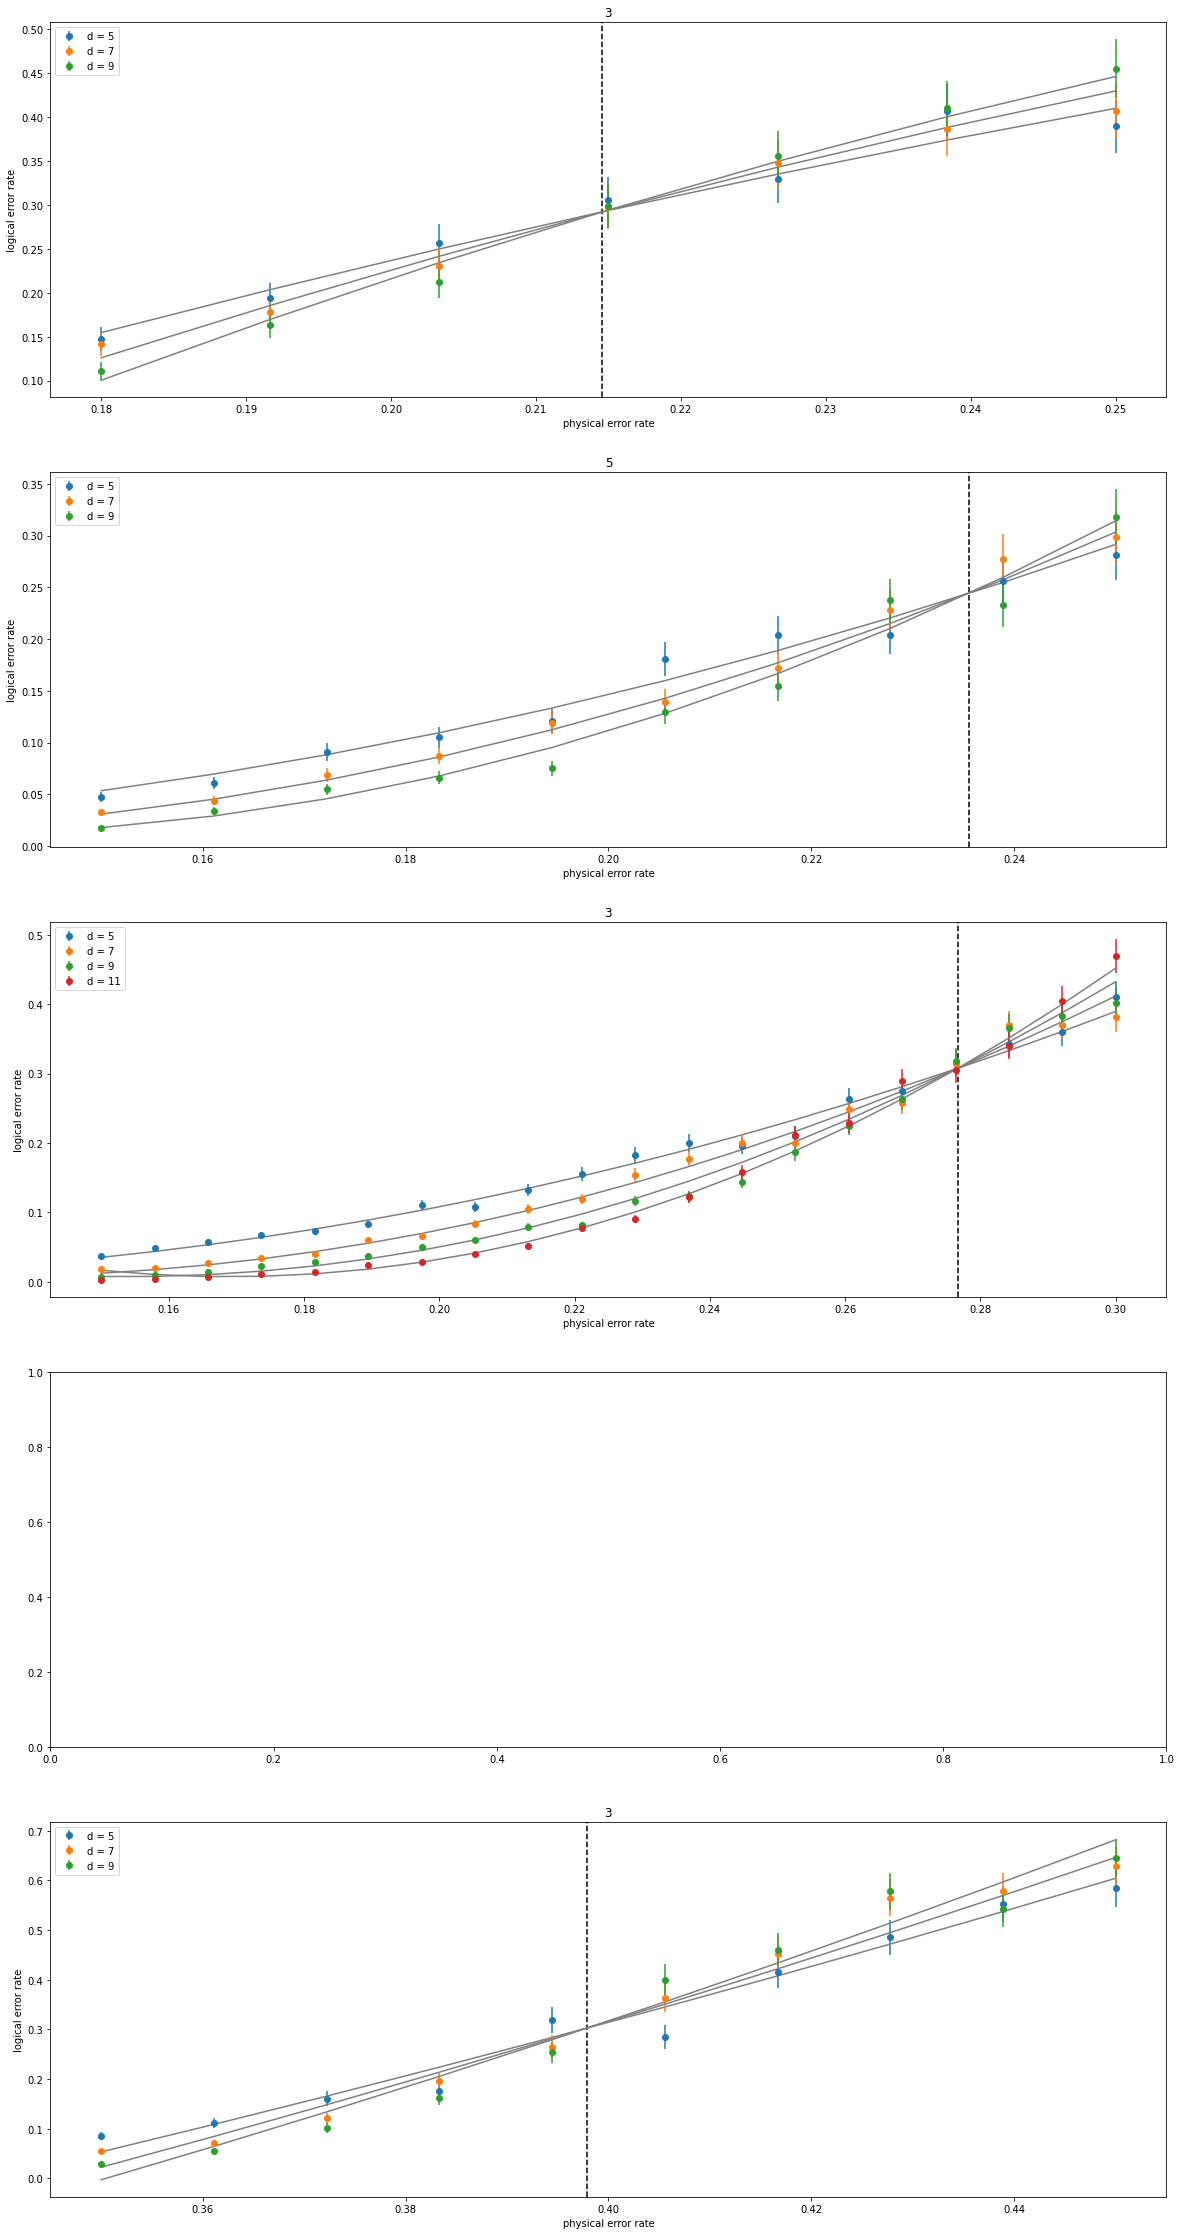

In [32]:
fig, axs = plt.subplots(nrows=5,figsize=(20,40))
XZZX_thresholds = dict()

XZZX_thresholds[3] = calculate_threshold(XZZX_code_data[3],ax=axs[0],title='3', calculate_threshold=True)
XZZX_thresholds[5] = calculate_threshold(XZZX_code_data[5],ax=axs[1],title='5',calculate_threshold=True)
XZZX_thresholds[10] = calculate_threshold(XZZX_code_data[10],ax=axs[2],title='3',calculate_threshold=True)
#XZZX_thresholds[30] = calculate_threshold(XZZX_code_data[30],ax=axs[3],title='3',calculate_threshold=True)
XZZX_thresholds[100] = calculate_threshold(XZZX_code_data[100],ax=axs[4],title='3',calculate_threshold=True)




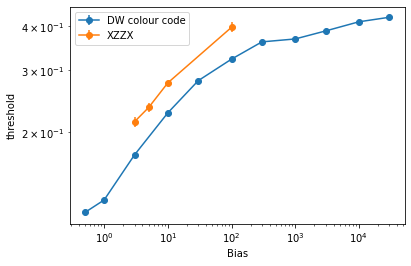

In [33]:
biases = list(cc_thresholds.keys())
threshold_plot= [thres[0] for thres in  cc_thresholds.values()]
threshold_errors = [thres[1] for thres in cc_thresholds.values()]
plt.errorbar(biases, threshold_plot,yerr=threshold_errors,marker='o',label='DW colour code')

biases = list(XZZX_thresholds.keys())
threshold_plot= [thres[0] for thres in  XZZX_thresholds.values()]
threshold_errors = [thres[1] for thres in XZZX_thresholds.values()]
plt.errorbar(biases, threshold_plot,yerr=threshold_errors,marker='o',label='XZZX')
plt.xlabel('Bias')
plt.ylabel('threshold')
plt.loglog()
plt.savefig('thresholdvsbias.png')
plt.legend()
plt.show()

# Plots I used to check the different thresholds at bias 10 and 30

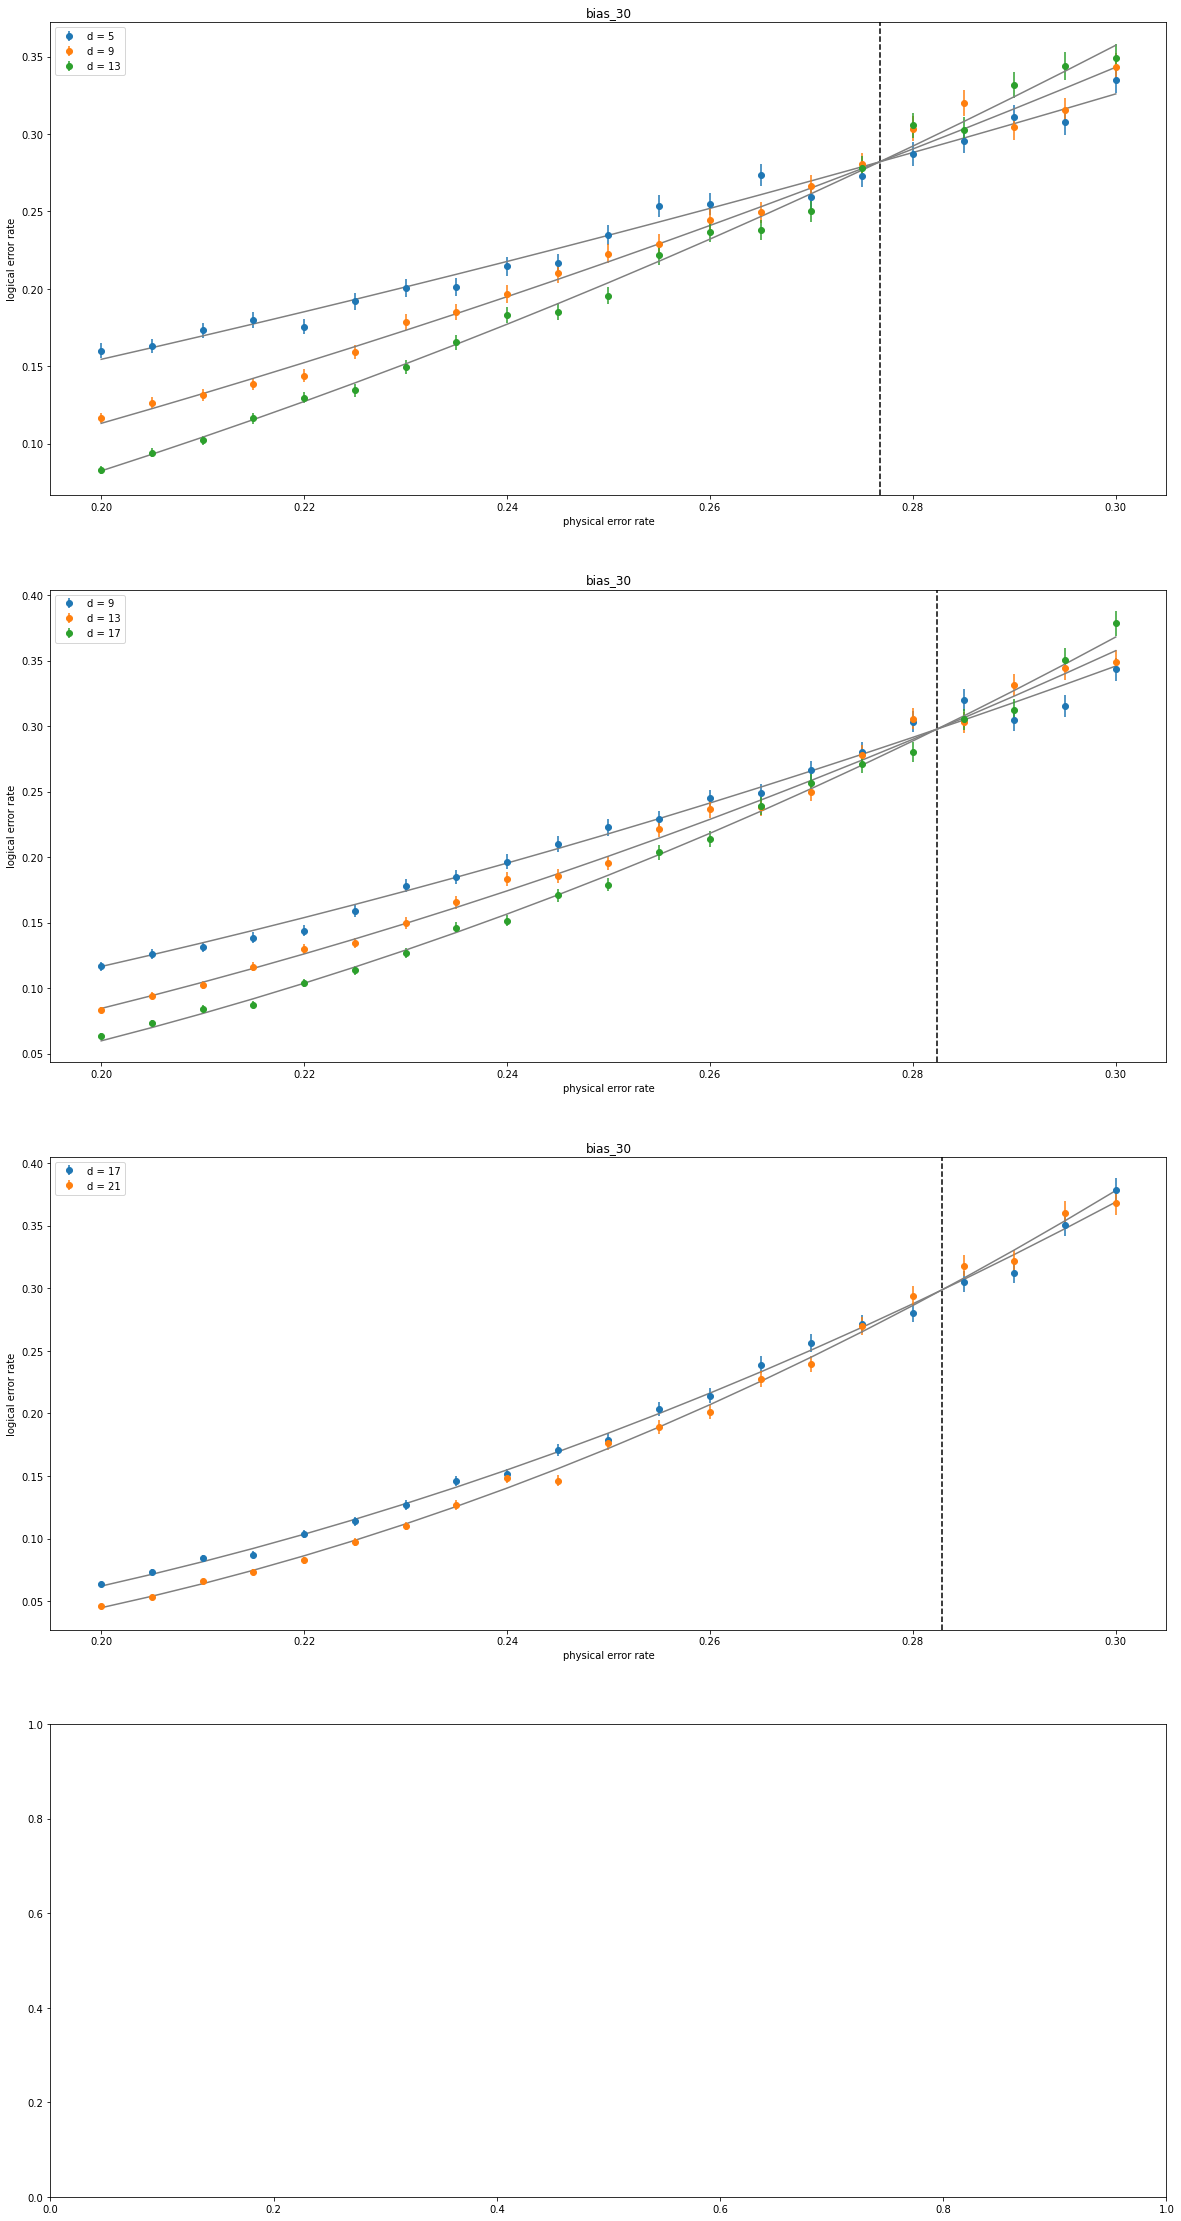

In [39]:
thresholds = dict()
fig, axs = plt.subplots(nrows=4,figsize=(20,40))

thresholds[(5,11,17)] = calculate_threshold(colour_code_data[30],ax=axs[0],title='bias_' + str(30),distances=[5,9,13],calculate_threshold=True)
thresholds[(7,13,19)] = calculate_threshold(colour_code_data[30],ax=axs[1],title='bias_' + str(30),distances=[9,13,17],calculate_threshold=True)
thresholds[(9,15,21)] = calculate_threshold(colour_code_data[30],ax=axs[2],title='bias_' + str(30),distances=[17,21,25],calculate_threshold=True)
#thresholds[(11,17,23)] = calculate_threshold(data[30],ax=axs[3],title='bias_' + str(30),distances=[21,25,29],calculate_threshold=True)


<ErrorbarContainer object of 3 artists>

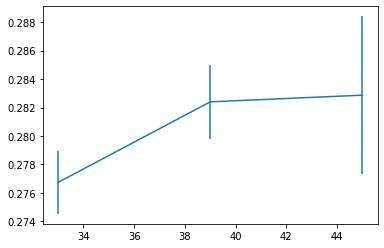

In [40]:
x_values = [sum(distances) for distances in thresholds.keys()]
y_values = [threshold[0] for threshold in thresholds.values()]
y_err = [threshold[1] for threshold in thresholds.values()]

plt.errorbar(x_values,y_values, yerr=y_err)

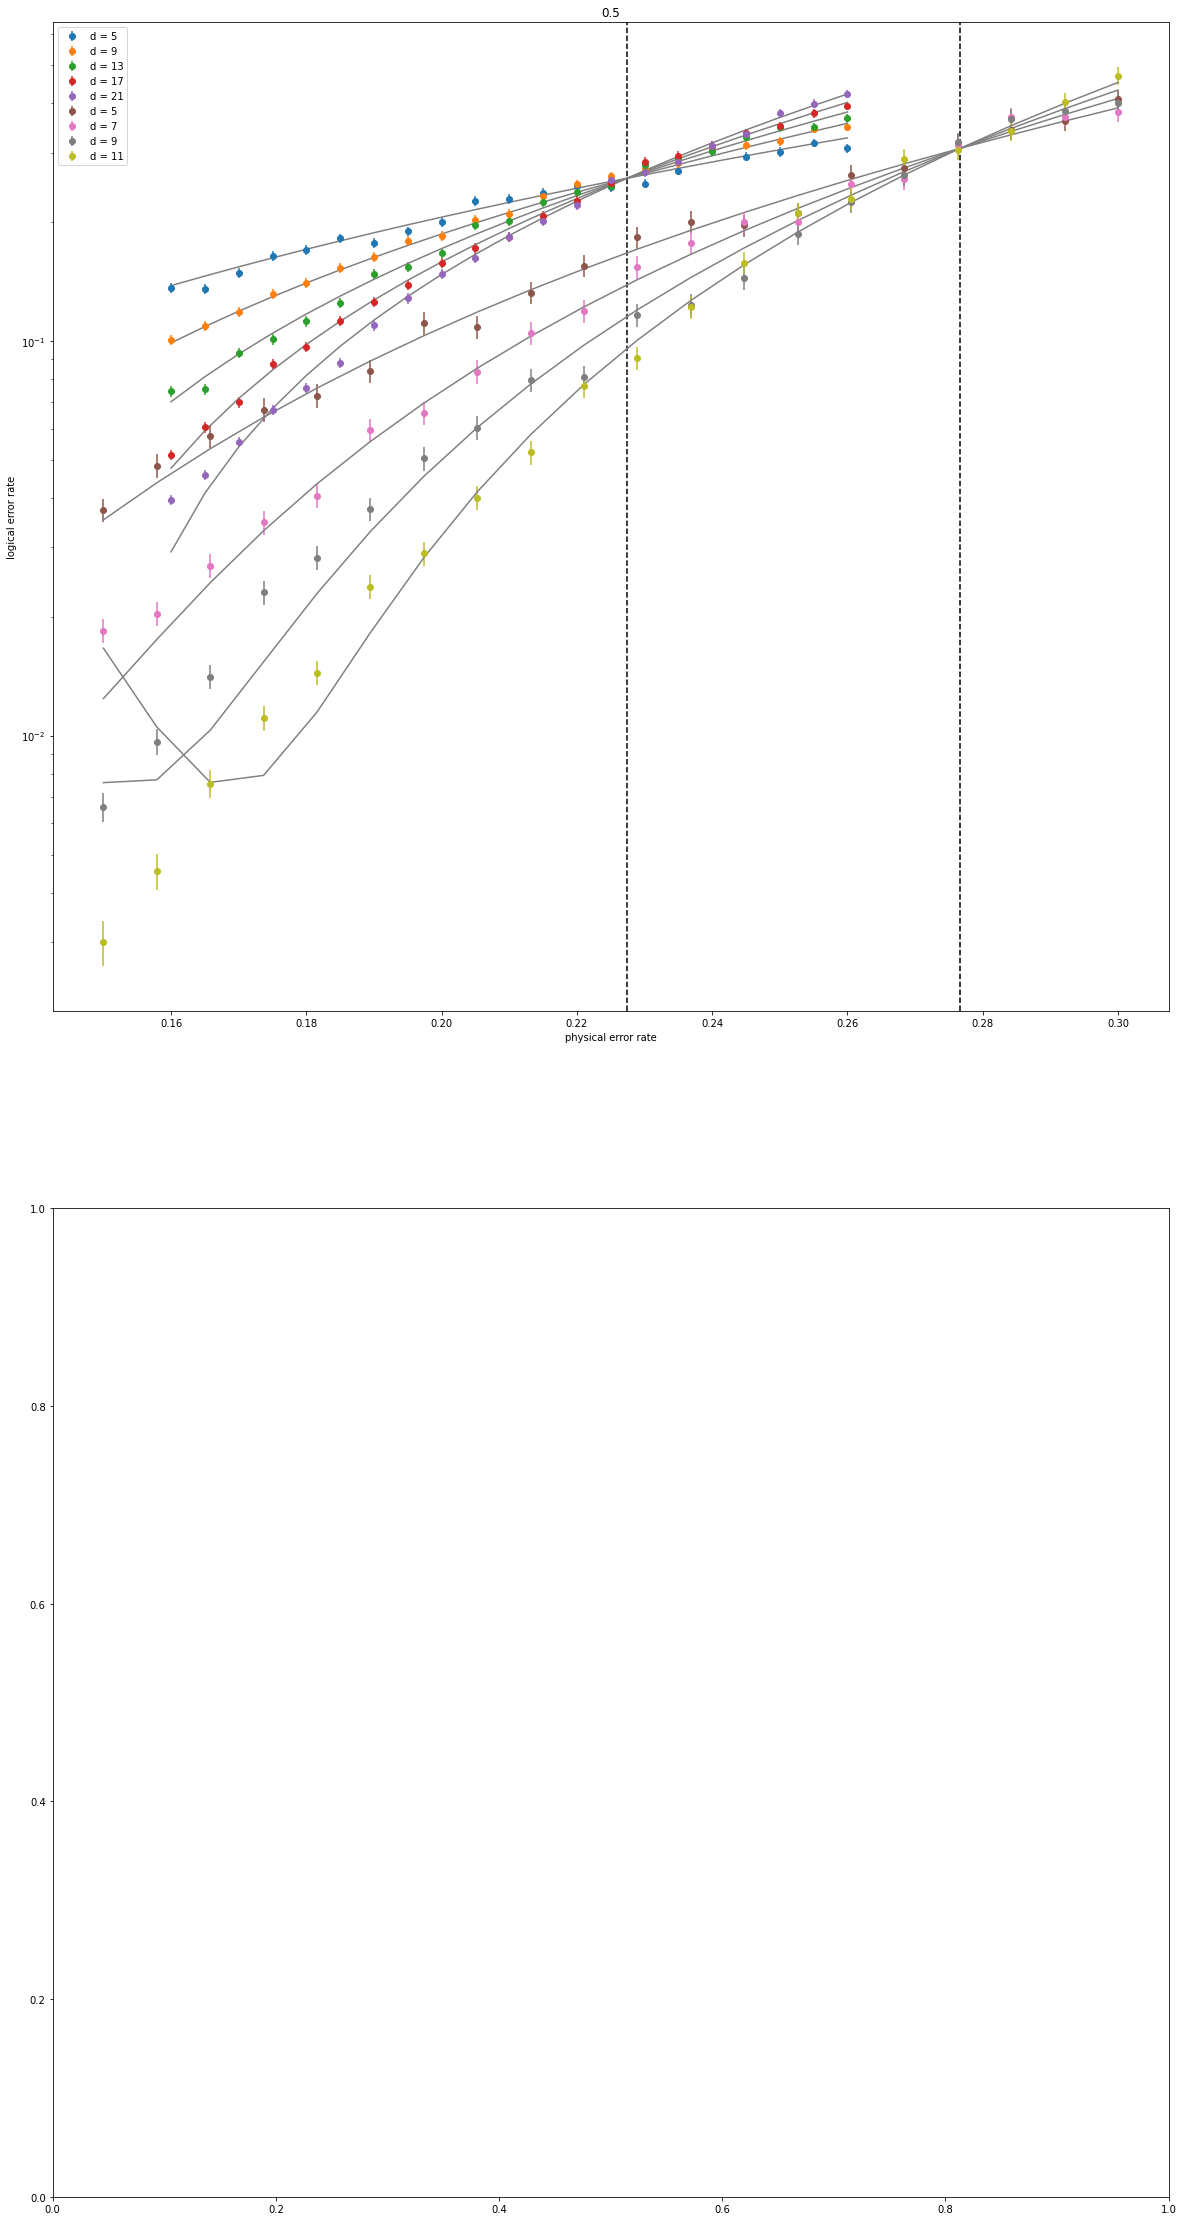

In [38]:
fig, axs = plt.subplots(nrows=2,figsize=(20,40))


calculate_threshold(colour_code_data[10],ax=axs[0],title='0.5', calculate_threshold=True)
calculate_threshold(XZZX_code_data[10],ax=axs[0],title='0.5', calculate_threshold=True)
axs[0].set_yscale('log')

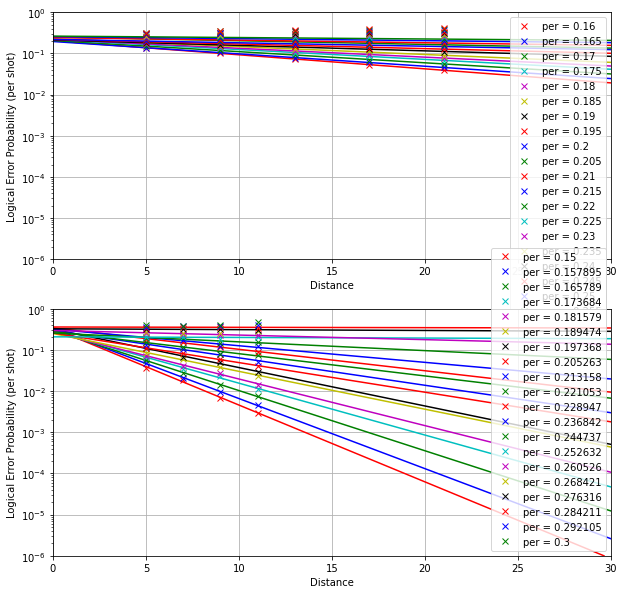

In [8]:
fig, axs = plt.subplots(nrows=2,figsize=(10,10))
line_fit_plot(axs[0],colour_code_data[10])
line_fit_plot(axs[1],XZZX_code_data[10])
for axis in axs:
    axis.set_yscale("log")
    axis.grid()
    axis.set_ylabel("Logical Error Probability (per shot)")
    axis.set_xlabel("Distance")
    axis.legend()
    axis.set_xlim([0, 30])
    axis.set_ylim([1e-6, 1e0])


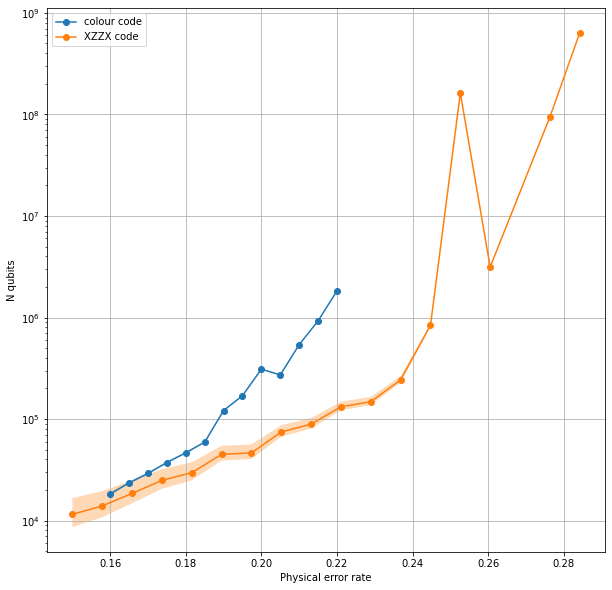

In [19]:
fig, axs = plt.subplots(nrows=1,figsize=(10,10))
def cc_n_qubits(d):
    return((d*d+(d-2)//2*(d-1))//2+d)

def sc_n_qubits(d):
    # specifically for bias 10
    return(d*(d*7)+(d-1)*(d*6))

teraquop_plot(axs, colour_code_data[10], cc_n_qubits, 0, 'colour code')
teraquop_plot(axs, XZZX_code_data[10], sc_n_qubits, 0, 'XZZX code')

#for axis in axs:
axs.set_yscale("log")
axs.grid()
axs.set_ylabel("N qubits")
axs.set_xlabel("Physical error rate")
#axs.set_xlim(0.25,0.4)
axs.legend()
